In [19]:
from ColorShapeSpace_sim import CSC2Env
from CogSSM import SSM, normal
import torch
import torch.nn.functional as F
from CSC_train_value import QAgent, build_value_obs, play_once, collect_batch_q, make_csc2_vector
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
%matplotlib inline
plt.ion()
import pickle
from scipy.ndimage import uniform_filter

In [20]:
with open("/home/bizon/Projects/mturk2/mturk2_code/CSC_sim/models/p1h2s1_ssm_csc_q_1d2000.pkl", "rb") as f:
    state_dict = pickle.load(f)
DIMS = 1
H = 2
S = 1
P = 1
CHUNK_SIZE = 64

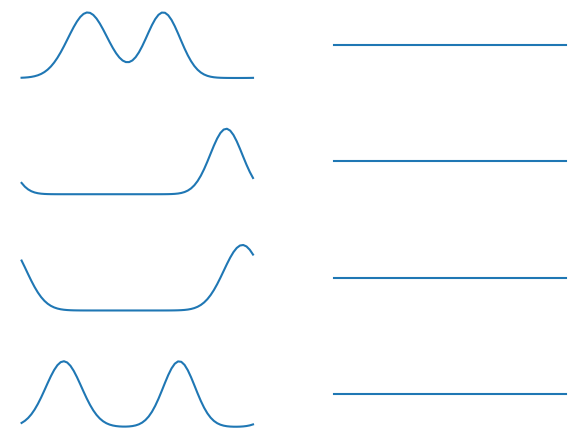

In [21]:
fig, axs = plt.subplots(4, 2)
fig.tight_layout()
for i, s in enumerate([756, 34, 2246, 4242]):
    env = CSC2Env(trials=CHUNK_SIZE * 15, render=False, n=72, render_reward=False, seed=s, one_d=DIMS==1)
    r_dist = env.reward_grid
    f_dists = env.freq_grid
    if DIMS == 2:
        axs[i, 0].imshow(r_dist)
        axs[i, 1].imshow(f_dists)
    else:
        axs[i, 0].plot(r_dist)
        axs[i, 1].plot(f_dists)
    axs[i, 0].set_xticks([])
    axs[i, 0].set_yticks([])
    axs[i, 0].set_xticklabels([])
    axs[i, 0].set_yticklabels([])
    axs[i, 0].axis('off')
    axs[i, 1].set_xticks([])
    axs[i, 1].set_yticks([])
    axs[i, 1].set_xticklabels([])
    axs[i, 1].set_yticklabels([])
    axs[i, 1].axis('off')
fig.savefig("example_env_dists.jpg")
plt.show()
    

In [22]:
model = QAgent(n_actions=2, obs_dim=2*DIMS + 1)
model.load_state_dict(state_dict)
#model.ssm.D.data = model.ssm.D.data * 0

<All keys matched successfully>

In [23]:
# shwo agent ENV
# track hidden state outs
model.reset()
model.sequential = True
model.reset()
states = play_once(agent=model, trials=CHUNK_SIZE*10, seed=34, render=False).numpy()
saved_cache = model.cache.clone()

Rendered episode total return: 210.50000000000054
Last 100 Average R: 0.17499999999999996


In [24]:
# generate batch of all stimuli 
angles = 2 * np.pi * np.arange(72) / 72
if DIMS == 2: 
    all_pairwise = np.meshgrid(angles, angles)
    all_pairwise = np.stack(all_pairwise, axis=2)
    all_pairwise = all_pairwise.reshape(1, -1, 2)
else:
    all_pairwise = angles.reshape(1, -1, 1)
obs = build_value_obs(all_pairwise, torch.zeros(1, device="cpu")).unsqueeze(0)
model.sequential = True
_, v_pred = model.forward(obs, k=all_pairwise.shape[1])
v_pred = v_pred.detach().to("cpu")
model.cache = saved_cache.clone()

tensor(-474.4838) tensor(1306.6046)


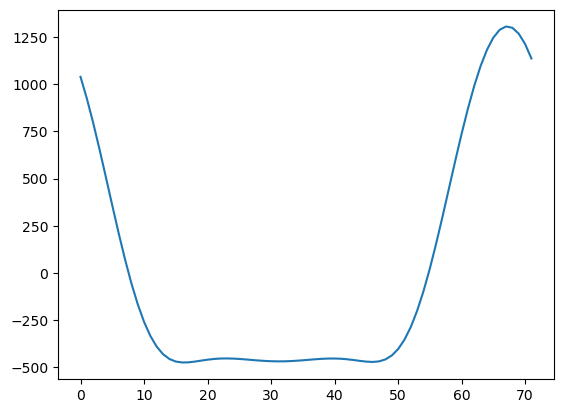

In [25]:
if DIMS == 2:
    v_pred = v_pred.reshape(36, 36).T
    plt.imshow(v_pred.numpy())
else:
    v_pred = v_pred.flatten()
    plt.plot(v_pred)
print(v_pred.min(), v_pred.max())

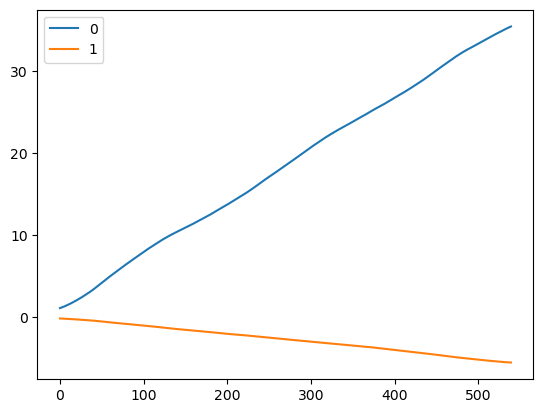

In [26]:
plt.plot(uniform_filter(states.reshape(64*10, H * S * P), 100, axes=(0,), mode="nearest")[:-100], label=[str(i) for i in range(H * S * P)])
plt.legend()

-12.891609 30.69171
-12.871345 30.327728


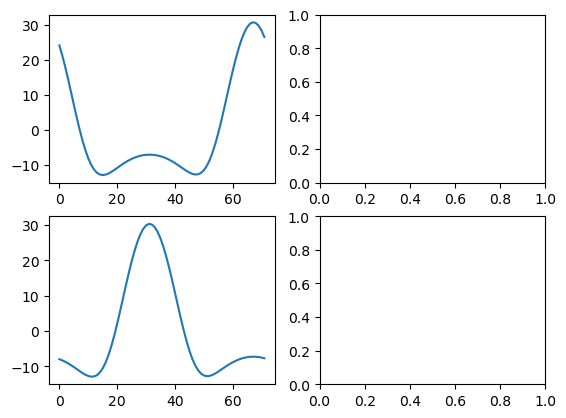

In [29]:
# we can recover states spaces by forcing certain states
try:
    del v_pred
except Exception:
    pass
fig, axs = plt.subplots(H, max(2, S))
h = H
s = S
for i in range(h):
    for j in range(s):
        state = torch.ones(72, 1, h, s, device="cpu") * 0.
        obs = build_value_obs(all_pairwise, torch.zeros(1, device="cpu")).unsqueeze(0)
        model.sequential = True
        model.cache.ssm_state = state.clone()
        model.cache.conv_state = model.cache.conv_state * 0.
        _, bias = model.forward(obs, k=all_pairwise.shape[1])
        state[:, :, i, j] = 1
        model.cache.ssm_state = state.clone()
        model.cache.conv_state = model.cache.conv_state * 0.
        _, v_pred = model.forward(obs, k=all_pairwise.shape[1])
        v_pred = v_pred.detach().to("cpu") - bias.detach().to("cpu")
        if DIMS == 2:
            v_pred = v_pred.reshape(36, 36).T
            res = v_pred.numpy()
            axs[i, j].imshow(res)
        else:
            v_pred = v_pred.flatten()
            res = v_pred.numpy()
            axs[i , j].plot(res)
        print(res.min(), res.max())
#model.cache = saved_cache.clone()


In [30]:
# manually multiply b(x)u(x) to get true filters
obs = build_value_obs(all_pairwise, torch.zeros(1, device="cpu")).unsqueeze(0)
conv = model.ssm.conv1d
conv.padding = 0
initial_weights = model.input.weight
in_bias = model.input.bias
linear_weights = model.ssm.in_proj.weight



In [31]:
inner = obs[0] @ initial_weights.T + in_bias
inner = inner @ linear_weights.T 
r_sig = torch.zeros_like(inner)
inner = torch.stack([inner, r_sig], dim=2)
xB = normal(conv(inner[:, :, :]))
B = xB[..., H:]
C = B.clone()
xBC = torch.cat([xB, C], dim=-1)

In [32]:
x = xBC[:, :H]
z = x.clone()
b = xBC[:, H:H+S].transpose(1, 2)
c = xBC[:, H+S:H+2*S].transpose(1, 2)
BX = x * b
CZ = z * c

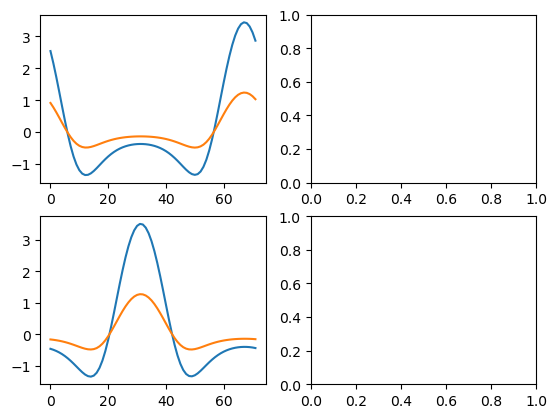

In [33]:
if DIMS==2:
    BX = BX.reshape(36, 36, H, S)
else:
    BX = BX.reshape(72, H, S)
fig, axs = plt.subplots(H, S + 1)
for i in range(H):
    for j in range(S):
        bx = BX[..., i, j].detach().cpu().numpy()
        cz = CZ[..., i, j].detach().cpu().numpy()
        if DIMS==1:
            axs[i, j].plot(bx)
            axs[i, j].plot(cz)
        else:
            axs[i, j].imshow(bx)
plt.show()

In [34]:
nx = x.detach().cpu().numpy().squeeze()
nb = b.detach().cpu().numpy().squeeze()
nc = c.detach().cpu().numpy().squeeze()
nz = z.detach().cpu().numpy().squeeze()

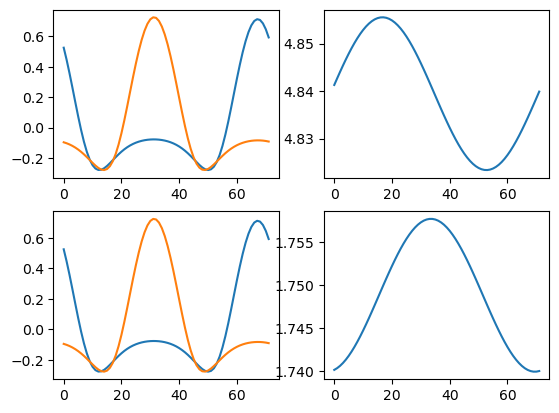

In [35]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(nx)
axs[0, 1].plot(nb)
axs[1, 0].plot(nz)
axs[1, 1].plot(nc)

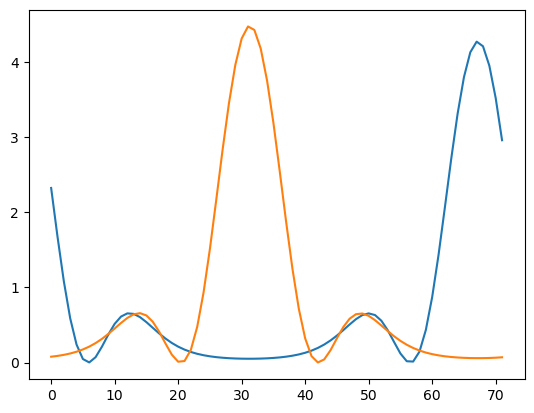

In [36]:
n = 1 
y = n * BX * CZ
plt.plot(y.detach().cpu().numpy().squeeze())

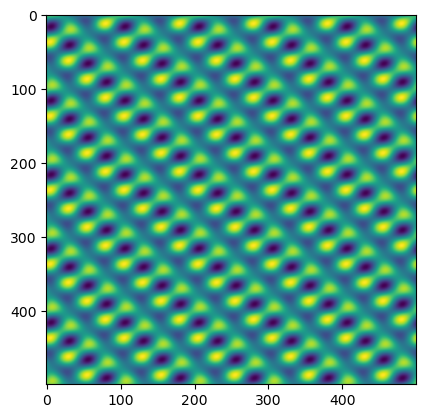

In [85]:
x = np.arange(500) * np.pi * 2 / 100
#x = np.cos(x)
m = x[:, None] 
m1 = np.cos(-2 * m + 2 * m.T - 2)
m2 = np.sin(3*m + 1 * m.T + 1)
m3 = np.cos(-2 * m + -2 * m.T - .5)
plt.imshow(m1 + m2 + m3)